# Example 2

Create a workspace without systematics and with signal strengths interpretation of the number of fitted events.

In [1]:
import countingworkspace
from countingworkspace import create_workspace, create_variables
import countingworkspace.utils
from countingworkspace.examples import NCATEGORIES, NPROCESS, EFFICIENCIES, EXPECTED_BKG_CAT, LUMI, XSECFID_X_BR_PRODUCTION_MODES, NAMES_PROC
import ROOT

countingworkspace.utils.silence_roofit()

Welcome to JupyROOT 6.14/08


Given the number of generated signal events ($T$) for each process $p$, the number of background events $b$ for each category $c$ and the probability ($\varepsilon$) for an event generated for process $p$ to be reconstructed in category $c$, the number of events recontructed ($R$) for each category $c$ is:

$$R_c = \sum_p(\varepsilon_{c,p} \cdot T_p) + b_c$$

or in matrix form:

$$\vec R = \varepsilon \cdot\vec T + \vec b$$

Knowing $\varepsilon$, $R$ and $b$ we want to invert the problem and find $T$. This is done with a maximum likelihood fit since the system of equations is generally overconstrained.

This time we want to parametrize $T$ in some way and to fit directly the parameters. The easiest way is with the signal strenghts and the luminosity $L$, e.g.

$$\vec T = L \vec \mu \circ \vec \sigma^{SM}$$

where $\sigma^{SM}$ is the cross section times Br predicted by the Standard Model. $\circ$ is the Hadamard produc (element by element). $\vec \mu$ are the free parameters in the fit.

In [4]:
print("number of categories: %s" % NCATEGORIES)
print("number of processes: %s" % NPROCESS)
print("background events in each categories: %s" % EXPECTED_BKG_CAT)
print("lumi (1/fb): %s" % LUMI)
print("xsections x Br (fb): %s" % XSECFID_X_BR_PRODUCTION_MODES)
print("names proc: %s" % NAMES_PROC)

number of categories: 29
number of processes: 4
background events in each categories: [1.3e+04 4.6e+04 1.9e+04 6.9e+03 6.4e+02 8.0e+01 7.7e+03 4.1e+03 6.9e+02
 6.1e+01 2.8e+02 3.5e+01 6.9e+02 3.2e+02 4.7e+02 1.1e+02 6.1e+02 9.8e+00
 6.5e+00 9.5e+01 5.3e+00 2.6e+00 5.5e+01 3.3e+01 8.2e+00 1.4e+00 4.7e+00
 4.9e+00 2.2e+00]
lumi (1/fb): 79.9
xsections x Br (fb): [101.5    7.99   4.53   1.33]
names proc: ['ggF', 'VBF', 'VH', 'TOP']


In [5]:
print(EFFICIENCIES)           # efficiencies: probability for a particular event for a particular
                              # truth-process to be selected in a particulare reco-category

[[7.59656034e-02 1.04604628e-02 1.45411863e-02 1.99323973e-04]
 [1.33594250e-01 2.02726463e-02 3.01054468e-02 4.64708281e-04]
 [6.32722516e-02 4.93284896e-02 4.10382246e-02 1.61497714e-03]
 [3.06301561e-02 5.44006917e-02 3.60505886e-02 1.75309571e-03]
 [5.80297648e-03 1.72063389e-02 1.08921484e-02 7.53345470e-04]
 [1.47098772e-03 5.09554732e-03 3.25223363e-03 2.83602730e-04]
 [1.64200334e-02 2.34817187e-02 3.26838551e-02 2.00158007e-02]
 [1.32634439e-02 2.65507197e-02 2.95846158e-02 2.05596601e-02]
 [5.41438547e-03 1.15379354e-02 1.34674271e-02 8.45197096e-03]
 [1.32996028e-03 2.26448816e-03 3.69473056e-03 2.83567831e-03]
 [1.58368047e-03 3.77259060e-02 7.13420676e-04 5.79753334e-04]
 [4.11651139e-04 3.59157521e-02 1.52405157e-04 4.01419976e-04]
 [3.02746026e-03 1.23900366e-02 3.90893629e-03 3.89613886e-03]
 [2.46153506e-03 3.04511703e-02 3.04539501e-03 6.76058076e-03]
 [2.55635930e-03 2.54552892e-03 2.21037070e-02 4.43348558e-03]
 [1.47979591e-03 1.28219234e-03 2.68690187e-02 2.910740

In [9]:
# first create the parameters needed for the parametrization. The luminosity
ws = ROOT.RooWorkspace()
ws.factory('lumi[%f]' % LUMI)
# and the cross sections:
ntrue = create_variables(ws, 'xsec_{proc}',  # {proc} is an index, you can call as you prefer
                 #nbins=NPROCESS,            # this is not necessary
                 bins=NAMES_PROC,            # the names
                 values=XSECFID_X_BR_PRODUCTION_MODES)

for l in ntrue:
    l.Print()
    
# we have all the ingredients to define the parametrization

RooRealVar::xsec_ggF = 101.5 C  L(-INF - +INF) 
RooRealVar::xsec_VBF = 7.99 C  L(-INF - +INF) 
RooRealVar::xsec_VH = 4.53 C  L(-INF - +INF) 
RooRealVar::xsec_TOP = 1.33 C  L(-INF - +INF) 


In [11]:
# specify which expression you want to use for the number of generated events (mu * lumi * xsection)
# instead of specifying how many generated events we expect, specify its expression
create_workspace(NCATEGORIES, NAMES_PROC,
                 efficiencies=EFFICIENCIES,
                 nexpected_bkg_cat=EXPECTED_BKG_CAT,
                 expression_nsignal_gen='prod:nsignal_gen_proc{proc}(mu_{proc}[1, -4, 5], lumi, xsec_{proc})',
                 ws=ws)
# get the pdf and the observables from the ModelConfig

pdf = ws.obj('ModelConfig').GetPdf()
obs = ws.obj('ModelConfig').GetObservables()

# check the expected yield for each categories
ws.set('all_exp').Print('V')

INFO:root:adding observables for 29 categories
INFO:root:adding efficiencies for 29 categories and 4 processes
INFO:root:adding expected events for 29 categories and 4 processes


  1) RooAddition::  nexp_cat0 = 13628
  2) RooAddition::  nexp_cat1 = 47107.3
  3) RooAddition::  nexp_cat2 = 19559.6
  4) RooAddition::  nexp_cat3 = 7196.37
  5) RooAddition::  nexp_cat4 = 702.068
  6) RooAddition::  nexp_cat5 = 96.3898
  7) RooAddition::  nexp_cat6 = 7862.11
  8) RooAddition::  nexp_cat7 = 4237.41
  9) RooAddition::  nexp_cat8 = 747.048
 10) RooAddition::  nexp_cat9 = 74.8701
 11) RooAddition:: nexp_cat10 = 317.247
 12) RooAddition:: nexp_cat11 = 61.3649
 13) RooAddition:: nexp_cat12 = 724.291
 14) RooAddition:: nexp_cat13 = 361.223
 15) RooAddition:: nexp_cat14 = 500.828
 16) RooAddition:: nexp_cat15 = 132.854
 17) RooAddition:: nexp_cat16 = 648.092
 18) RooAddition:: nexp_cat17 = 11.0957
 19) RooAddition:: nexp_cat18 = 8.94346
 20) RooAddition:: nexp_cat19 = 106.184
 21) RooAddition:: nexp_cat20 = 8.07608
 22) RooAddition:: nexp_cat21 = 4.24262
 23) RooAddition:: nexp_cat22 = 61.2151
 24) RooAddition:: nexp_cat23 = 39.7326
 25) RooAddition:: nexp_cat24 = 12.3664
 2

## Asimov

In [12]:
# generate the Asimov, the values should be equal to the expected ones

data_asimov = ROOT.RooStats.AsymptoticCalculator.GenerateAsimovData(pdf, obs)
data_asimov.Print('V')

DataStore CountingAsimovData0 (CountingAsimovData0)
  Contains 1 entries
  Observables: 
    1)   nobs_cat0 = 13628  L(0 - 100000)  "nobs_cat0"
    2)   nobs_cat1 = 47107.3  L(0 - 100000)  "nobs_cat1"
    3)   nobs_cat2 = 19559.6  L(0 - 100000)  "nobs_cat2"
    4)   nobs_cat3 = 7196.37  L(0 - 100000)  "nobs_cat3"
    5)   nobs_cat4 = 702.068  L(0 - 100000)  "nobs_cat4"
    6)   nobs_cat5 = 96.3898  L(0 - 100000)  "nobs_cat5"
    7)   nobs_cat6 = 7862.11  L(0 - 100000)  "nobs_cat6"
    8)   nobs_cat7 = 4237.41  L(0 - 100000)  "nobs_cat7"
    9)   nobs_cat8 = 747.048  L(0 - 100000)  "nobs_cat8"
   10)   nobs_cat9 = 74.8701  L(0 - 100000)  "nobs_cat9"
   11)  nobs_cat10 = 317.247  L(0 - 100000)  "nobs_cat10"
   12)  nobs_cat11 = 61.3649  L(0 - 100000)  "nobs_cat11"
   13)  nobs_cat12 = 724.291  L(0 - 100000)  "nobs_cat12"
   14)  nobs_cat13 = 361.223  L(0 - 100000)  "nobs_cat13"
   15)  nobs_cat14 = 500.828  L(0 - 100000)  "nobs_cat14"
   16)  nobs_cat15 = 132.854  L(0 - 100000)  "nobs_ca

In [13]:
# fit the pdf with the Asimov dataset
fr = pdf.fitTo(data_asimov, ROOT.RooFit.Save())

 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 mu_TOP       1.00000e+00  9.00000e-01   -4.00000e+00  5.00000e+00
     2 mu_VBF       1.00000e+00  9.00000e-01   -4.00000e+00  5.00000e+00
     3 mu_VH        1.00000e+00  9.00000e-01   -4.00000e+00  5.00000e+00
     4 mu_ggF       1.00000e+00  9.00000e-01   -4.00000e+00  5.00000e+00
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        2000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=101.271 FROM MIGRAD    STATUS=INITIATE       16 CALLS          17 TOTAL
         

In [14]:
# print the results
fr.Print()


  RooFitResult: minimized FCN value: 101.271, estimated distance to minimum: 2.46569e-11
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                mu_TOP    1.0000e+00 +/-  3.23e-01
                mu_VBF    1.0000e+00 +/-  2.94e-01
                 mu_VH    1.0000e+00 +/-  5.32e-01
                mu_ggF    1.0000e+00 +/-  1.10e-01



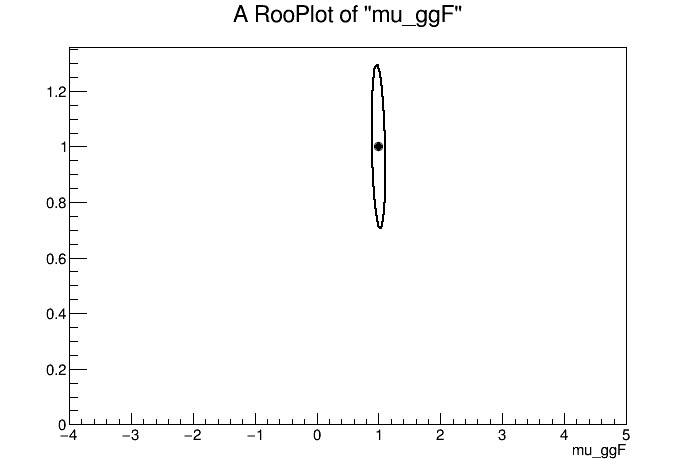

In [18]:
canvas = ROOT.TCanvas()
plot = ws.obj('mu_ggF').frame()
fr.plotOn(plot, 'mu_ggF', 'mu_VBF')
plot.Draw()
canvas.Draw()